In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

In [ ]:
mean_gray = 0.1307
stddev_gray = 0.3081

transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((mean_gray,),(stddev_gray,))])

train_dataset = datasets.MNIST(root = './root',transform = transforms,download = True,train = True)
test_dataset = datasets.MNIST(root = './root',transform = transforms,download = False,train = False)

100%|██████████| 9912422/9912422 [00:00<00:00, 170840365.07it/s]

Extracting ./root/MNIST/raw/train-images-idx3-ubyte.gz to ./root/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 11724321.90it/s]


Extracting ./root/MNIST/raw/train-labels-idx1-ubyte.gz to ./root/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 66058144.66it/s]

Extracting ./root/MNIST/raw/t10k-images-idx3-ubyte.gz to ./root/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19518984.39it/s]


Extracting ./root/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./root/MNIST/raw



In [ ]:
from torch.utils.data import DataLoader

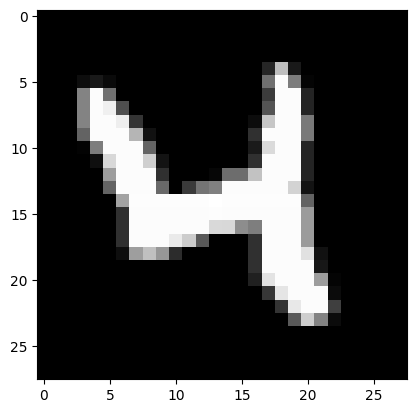

In [ ]:
import matplotlib.pyplot as plt
random_image = train_dataset[20][0].numpy() * stddev_gray + mean_gray
plt.imshow(random_image.reshape(28,28),cmap = 'gray')

In [ ]:
train_dataset[20][1]

4

In [ ]:
batch_size = 100

train_loader = DataLoader(dataset = train_dataset,shuffle = True,batch_size = batch_size)
test_loader = DataLoader(dataset = test_dataset,shuffle = False , batch_size = batch_size)

In [ ]:
print('There are {} images in the training set'.format(len(train_dataset)))
print('There are {} images in the test set'.format(len(test_dataset)))
print('There are {} batches in the train loader'.format(len(train_loader)))
print('There are {} batches in the testloader'.format(len(test_loader)))

There are 60000 images in the training set
There are 10000 images in the test set
There are 600 batches in the train loader
There are 100 batches in the testloader


In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN,self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1,out_channels=8,kernel_size = 3,padding = 1,stride = 1)
    self.batchnorm1 = nn.BatchNorm2d(num_features= 8)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size= 2)
    self.cnn2 = nn.Conv2d(in_channels=8,out_channels=32,kernel_size = 5,padding=2,stride=1)
    self.batchnorm2 = nn.BatchNorm2d(num_features = 32)
    self.fc1 = nn.Linear(1568,600)
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(600,10)


  def forward(self,x):
    out = self.cnn1(x)
    out = self.batchnorm1(out)
    out = self.relu(out)
    out = self.maxpool(out)
    out = self.cnn2(out)
    out = self.batchnorm2(out)
    out = self.relu(out)
    out = self.maxpool(out)
    out = out.view(-1,1568)
    out = self.fc1(out)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.fc2(out)
    return out


In [ ]:
model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
  model = model.cuda()
loss_fn = nn.CrossEntropyLoss(reduction = 'mean')
optimiser = torch.optim.Adam(params = model.parameters(),lr = 0.01)


In [ ]:
iteration = 0
correct = 0

for i,(inputs,labels) in enumerate(train_loader):
  if CUDA:
    inputs = inputs.cuda()
    labels = labels.cuda()

  print("For one iteration, this is what happens:")
  print("Input Shape:",inputs.shape)
  print("Labels Shape:",labels.shape)
  output = model(inputs)
  print('Outputs Shape',output.shape)
  _,predicted = torch.max(output,1)
  print("Predicted Shape",predicted.shape)
  print("Predicted Tensor:")
  print(predicted)
  correct += (predicted == labels).sum()
  break

For one iteration, this is what happens:
Input Shape: torch.Size([100, 1, 28, 28])
Labels Shape: torch.Size([100])
Outputs Shape torch.Size([100, 10])
Predicted Shape torch.Size([100])
Predicted Tensor:
tensor([5, 4, 9, 4, 9, 5, 5, 4, 5, 5, 4, 9, 9, 0, 8, 4, 2, 5, 9, 8, 8, 5, 0, 4,
        5, 5, 5, 9, 8, 5, 5, 4, 4, 5, 8, 5, 4, 5, 5, 5, 0, 4, 5, 4, 4, 8, 4, 7,
        5, 4, 5, 0, 5, 4, 5, 4, 5, 8, 9, 4, 8, 5, 4, 5, 4, 7, 5, 0, 4, 5, 4, 5,
        5, 6, 5, 4, 9, 8, 9, 4, 9, 9, 4, 9, 5, 5, 5, 5, 4, 8, 5, 4, 4, 5, 4, 4,
        8, 5, 4, 7], device='cuda:0')


In [ ]:
epochs = 12

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
  correct = 0
  iterations = 0
  iter_loss = 0.0

  model.train()

  for i,(inputs,labels) in enumerate(train_loader):
    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()

    outputs = model(inputs)
    loss = loss_fn(outputs,labels)
    iter_loss += loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    _,predictions = torch.max(outputs,1)
    correct += (predictions == labels).sum().item()
    iterations += 1

  train_loss.append(iter_loss/iterations)
  train_accuracy.append(correct/len(train_dataset) * 100)

  correct = 0
  testing_loss = 0
  iterations = 0

  model.eval()

  for inputs,labels in test_loader:
    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()

    outputs = model(inputs)
    loss = loss_fn(outputs,labels)
    testing_loss += loss.item()

    _,predictions = torch.max(outputs,1)
    correct += (predictions == labels).sum().item()
    iterations += 1

  test_loss.append(testing_loss/iterations)
  test_accuracy.append(correct/len(test_dataset)* 100)

  print('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}'
           .format(epoch+1, epochs, train_loss[-1], train_accuracy[-1],
             test_loss[-1], test_accuracy[-1]))


Epoch 1/25, Training Loss: 0.157, Training Accuracy: 95.343, Testing Loss: 0.067, Testing Acc: 97.920
Epoch 2/25, Training Loss: 0.117, Training Accuracy: 96.628, Testing Loss: 0.042, Testing Acc: 98.720
Epoch 3/25, Training Loss: 0.093, Training Accuracy: 97.288, Testing Loss: 0.040, Testing Acc: 98.770
Epoch 4/25, Training Loss: 0.076, Training Accuracy: 97.805, Testing Loss: 0.036, Testing Acc: 98.920
Epoch 5/25, Training Loss: 0.072, Training Accuracy: 97.922, Testing Loss: 0.065, Testing Acc: 98.110
Epoch 6/25, Training Loss: 0.067, Training Accuracy: 98.063, Testing Loss: 0.036, Testing Acc: 98.980
Epoch 7/25, Training Loss: 0.068, Training Accuracy: 98.040, Testing Loss: 0.036, Testing Acc: 99.110
Epoch 8/25, Training Loss: 0.062, Training Accuracy: 98.165, Testing Loss: 0.035, Testing Acc: 99.050
Epoch 9/25, Training Loss: 0.057, Training Accuracy: 98.392, Testing Loss: 0.045, Testing Acc: 98.930
Epoch 10/25, Training Loss: 0.058, Training Accuracy: 98.328, Testing Loss: 0.045,

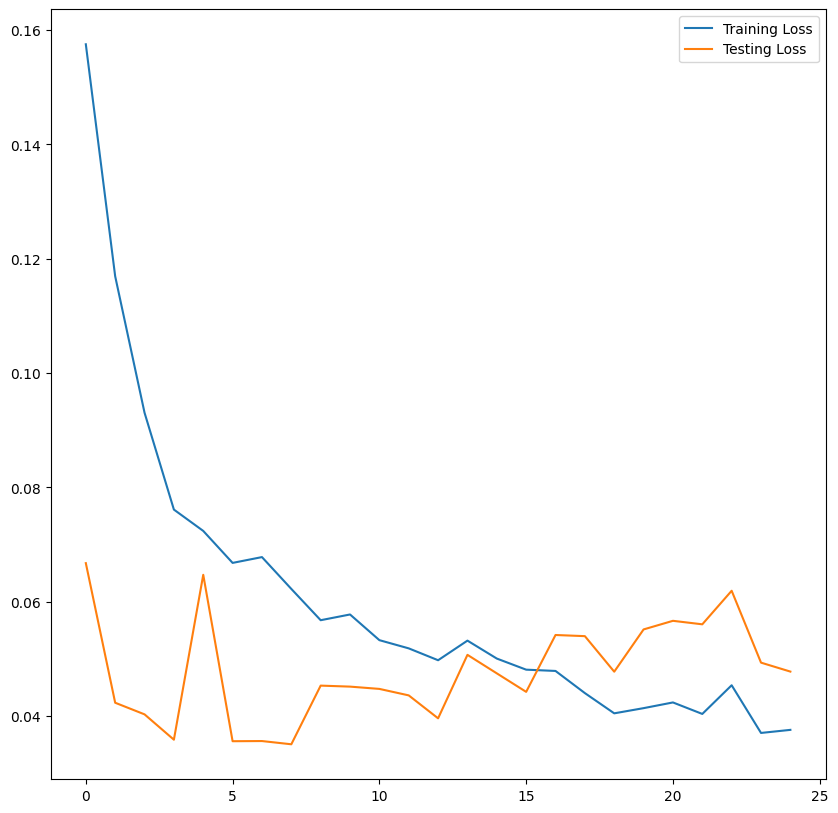

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()

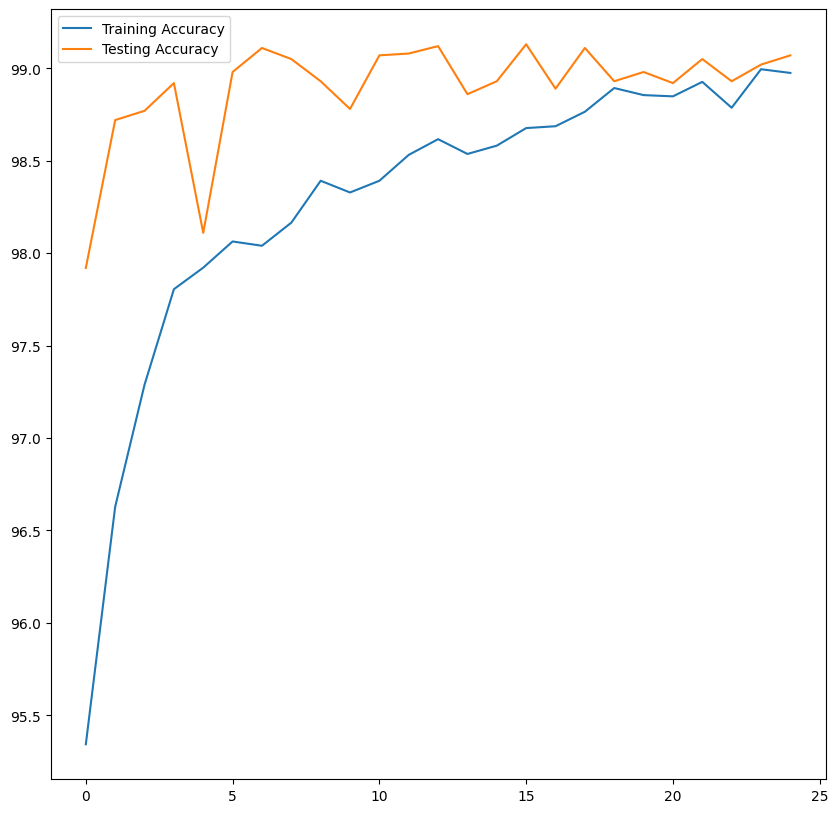

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()

In [ ]:
img = test_dataset[30][0].resize_((1, 1, 28, 28))   #(batch_size,channels,height,width)
label = test_dataset[30][1]

model.eval()

if CUDA:
    model = model.cuda()
    img = img.cuda()

output = model(img)
_, predicted = torch.max(output,1)
print("Prediction is: {}".format(predicted.item()))
print("Actual is: {}".format(label))

Prediction is: 3
Actual is: 3


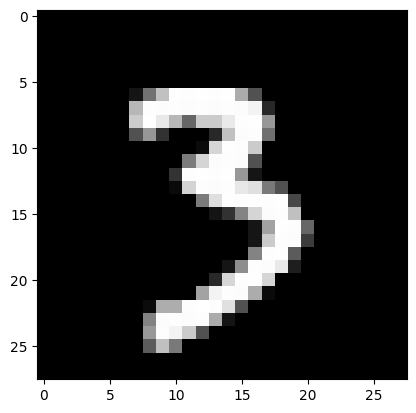

In [ ]:
plt.imshow(test_dataset[30][0].resize_((28, 28)),cmap = 'gray')